In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob

### TUNING PARAMETERS

In [25]:
# number of chessboard corners
nx = 9
ny = 6
# determine image size
img = cv2.imread('./camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])
# sobel thresholds

# color thresholds

# warp
src = np.float32([[1030, 660], [740, 480], [550, 480], [275, 660]])
dst = np.float32([[1050, 700], [1050, 0], [270, 0] , [270, 700]])

### Camera Calibration

[Camera_Calibration_Code](https://github.com/udacity/CarND-Camera-Calibration)

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.4

img_calib = glob.glob('./camera_cal/*')

for fname in img_calib:
    img = cv2.cvtColor(cv2.imread(fname.strip()), cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx,ny), None)
    # if found, add object points, image points
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # draw and display corners
#         cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

# camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


In [4]:
def undistort(img, mtx, dist):
    img_udist = cv2.undistort(img, mtx, dist, None, mtx)

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()

#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=40)
#     ax1.plot(1035, 660, 'ro', linewidth=2.0)
#     ax1.plot(275, 660, 'ro', linewidth=2.0)
#     ax1.plot(740, 480, 'ro', linewidth=2.0)
#     ax1.plot(550, 480, 'ro', linewidth=2.0)

#     ax2.imshow(img_udist)
#     ax2.set_title('Undistorted and Warped Image', fontsize=40)
#     ax2.plot(1035, 660, 'ro', linewidth=2.0)
#     ax2.plot(275, 660, 'ro', linewidth=2.0)
#     ax2.plot(740, 480, 'ro', linewidth=2.0)
#     ax2.plot(550, 480, 'ro', linewidth=2.0)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return img_udist

### Camera Undistortion Visualization

In [ ]:
# # Visualize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(img, cmap='gray')
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(dst, cmap='gray')
# ax2.set_title('Undistorted Image', fontsize=30)

### PERSPECTIVE TRANSFORM

In [ ]:
# M = cv2.getPerspectiveTransform(src, dst)
# Minv = cv2.getPerspectiveTransform(dst, src)
# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


In [6]:
def color_binary(img_channel, c_tmin=175, c_tmax=255, sx_tmin=20, sx_tmax=100, SOBEL=False):
    binary = np.zeros_like(img_channel)
    if SOBEL==True:
        sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        binary[(scaled_sobel >= sx_tmin) & (scaled_sobel <= sx_tmax)] = 1
        return binary
    else:
        binary[(img_channel >= c_tmin) & (img_channel <= c_tmax)] = 1
        return binary
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [26]:
def process_image(img):
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    #     img_ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)

    # undistort image
    img = cv2.undistort(img_hls, mtx, dist, None, mtx)
    
    # ROI
    left_bottom = [170,img.shape[0]]
    left_top = [600, 430]
    right_top = [740, 430]
    right_bottom = [img.shape[1], img.shape[0]]
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    img_roi = region_of_interest(img, vertices)

#     overlay = hough_lines(img_roi, 1, (np.pi)/180, 20, 50, 500)
    

    sxbinary = color_binary(img_roi[:,:,2], c_tmin=175, c_tmax=255, sx_tmin=20, sx_tmax=100, SOBEL=True)
    cbinary = color_binary(img_roi[:,:,2], c_tmin=175, c_tmax=255, sx_tmin=20, sx_tmax=100, SOBEL=False)

    stack_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, cbinary))
    stack_binary=np.uint8(255*stack_binary/np.max(stack_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(cbinary == 1) | (sxbinary == 1)] = 1
#     return weighted_img(overlay, img_rgb)
    return combined_binary

In [ ]:
cap = cv2.VideoCapture('./project_video.mp4')

while(cap.isOpened):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    
     # Display the resulting frame
    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame',stack_binary)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

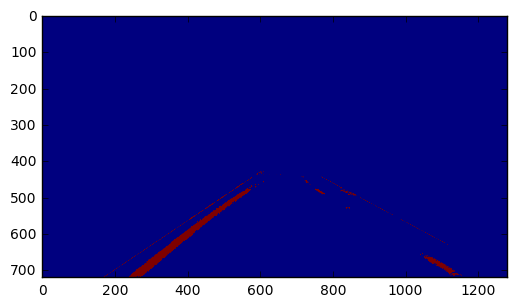

In [40]:
img_out = process_image(img)
plt.imshow(img_out)

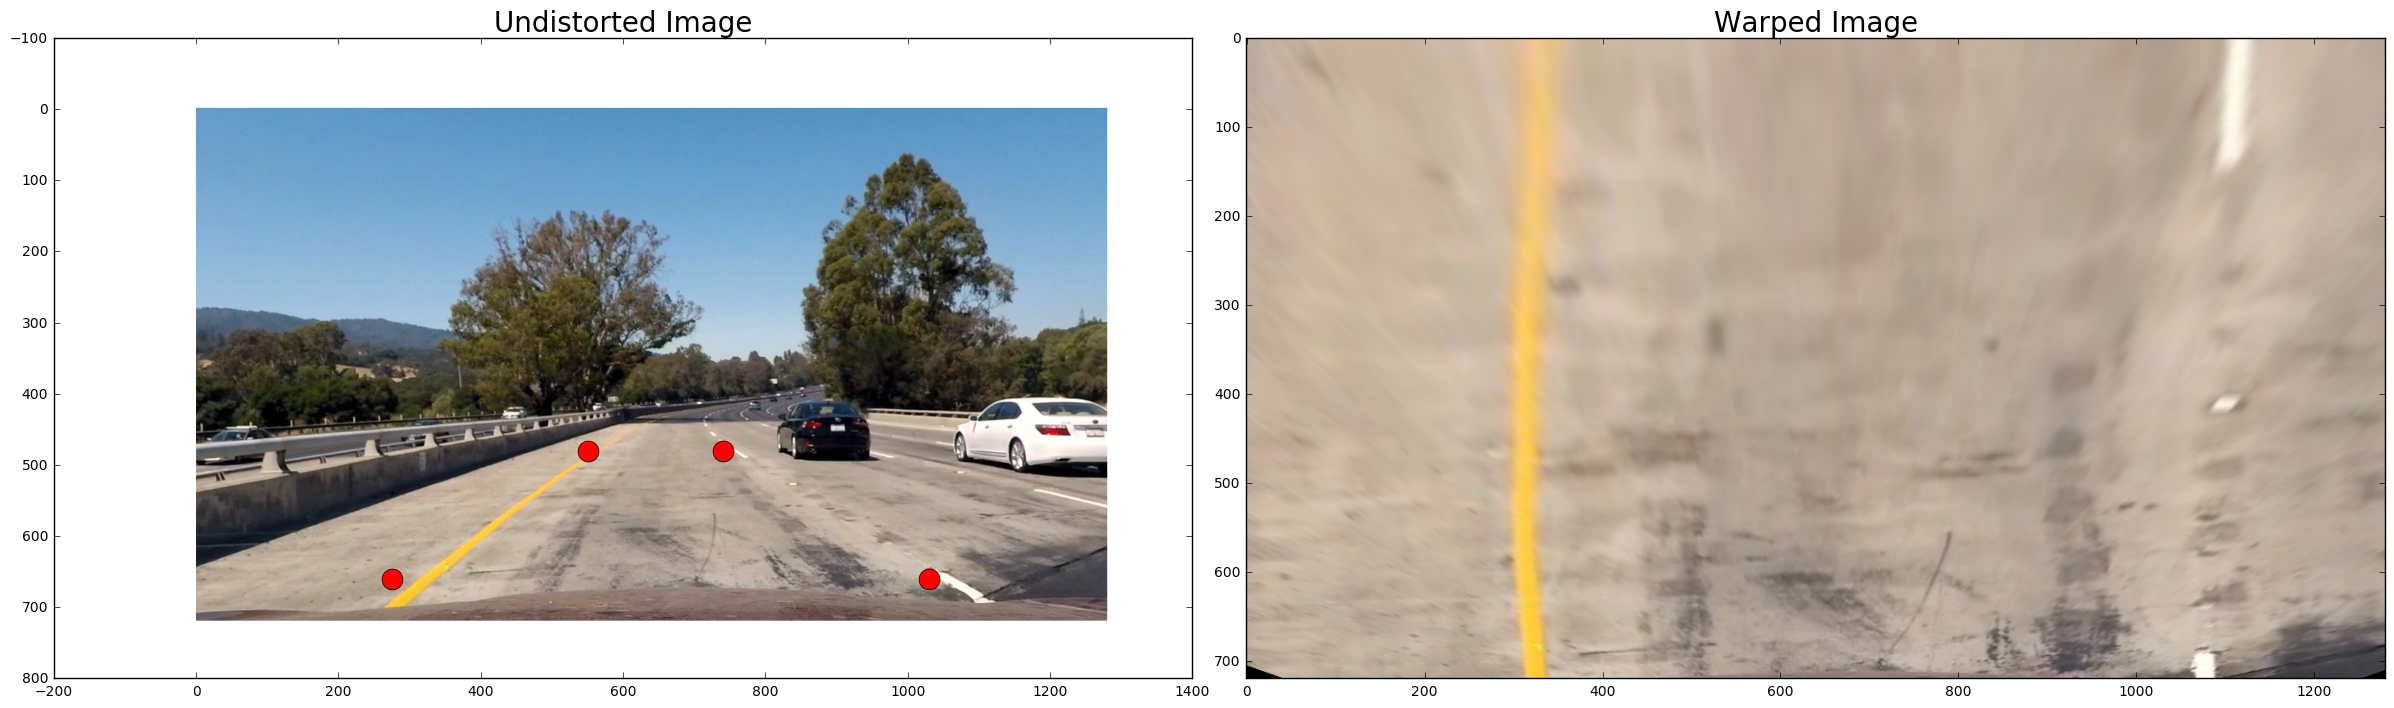

In [39]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)

# cbinary = color_binary(I[:,:,2], c_tmin=100,SOBEL=False)
left_bottom = [275,660]
left_top = [615, 430]
right_top = [660, 430]
right_bottom = [1035, 660]

src = np.float32([[1030, 660], [740, 480], [550, 480], [275, 660]])
dst = np.float32([[1050, 700], [1050, 0], [270, 0] , [270, 700]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0] ), flags=cv2.INTER_LINEAR)

vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
img_roi = region_of_interest(img, vertices)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=20)
ax1.plot(1030, 660, 'ro', ms=15.0)
ax1.plot(275, 660, 'ro', ms=15.0)
ax1.plot(740, 480, 'ro', ms=15.0)
ax1.plot(550, 480, 'ro', ms=15.0)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

## ONLY TO WRITE VIDEO
white_output = './video_out.mp4'
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./video_out.mp4
[MoviePy] Writing video ./video_out.mp4


100%|█████████▉| 1260/1261 [02:15<00:00,  9.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_out.mp4 

Wall time: 2min 15s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))